In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [2]:
dataset = pd.read_csv("../NS2021_Dicer/wine-dataset.csv")

In [3]:
dataset

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [4]:
# kvalita vín je ohodnotená na stupnici 0 až 10
# najlepšie vína sú v datasete ohodnotené deviatimi bodmi a najhoršie tromi.
# Kedže tieto čísla nie su pre nás ideálne rozdelíme si ich do kategórií:
# nízka kvalita (0) , stredná kvalita (1) , vysoká kvalita (2)
bins= [0, 5.5, 7.5, 10] # vína s hodnotením 3-5 spadajú do kategórie nízka kvalita, 6-7 je stredná a 8-9 vysoká 
labels = [0, 1, 2]
dataset['quality'] = pd.cut(dataset['quality'], bins=bins, labels=labels)

In [5]:
dst = dataset.fillna(dataset.mean())
dst

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.450000,8.8,1
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.490000,9.5,1
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.440000,10.1,1
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.400000,9.9,1
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.400000,9.9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.580000,10.5,0
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.531215,11.2,1
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.750000,11.0,1
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.710000,10.2,0


In [16]:
dst.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801
std,1.295751,0.164548,0.145231,4.757392,0.035031,17.749400,56.521855,0.002999,0.160637,0.148768,1.192712
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000


In [15]:
means = dst.groupby('quality').mean()
means

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
quality,,,,,,,,,,,
0,7.332040,0.397506,0.304182,5.646225,0.064412,29.480495,119.277055,0.995756,3.214398,0.524225,9.873544
1,7.164551,0.306938,0.326809,5.326102,0.051717,30.960281,113.505747,0.994164,3.220478,0.536478,10.807612
2,6.855134,0.291187,0.333889,5.351010,0.040778,34.505051,117.479798,0.992487,3.225354,0.511313,11.691414


C:\Users\dicer\anaconda3\lib\site-packages\matplotlib\axes\_base.py:405: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


Text(0.5, 0, 'KVALITA (0 = nizka, 1 = stredna, 2 = vysoka)')

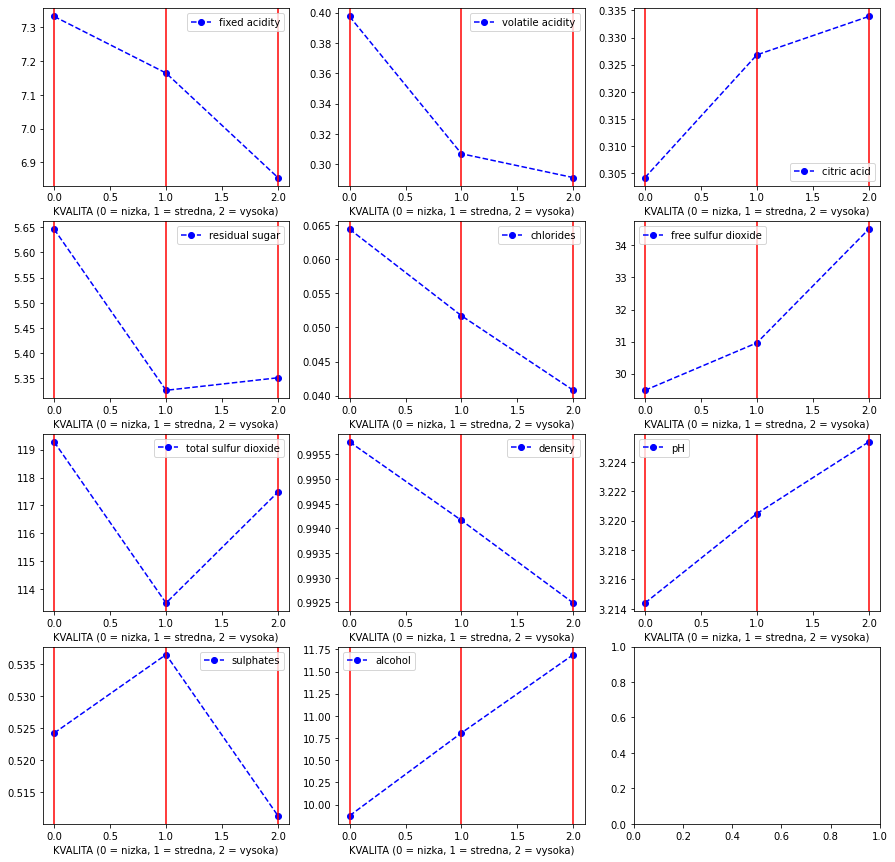

In [7]:
fig, axs = plt.subplots(4,3)
fig.set_figheight(15)
fig.set_figwidth(15)

axs[0,0].plot(means["fixed acidity"],'bo',linestyle='--',label="fixed acidity")
axs[0,0].legend(loc="upper right")
axs[0,0].axvline(x=0,color="r")
axs[0,0].axvline(x=1,color="r")
axs[0,0].axvline(x=2,color="r")
axs[0,0].set_xlabel('KVALITA (0 = nizka, 1 = stredna, 2 = vysoka)')

axs[0,1].plot(means["volatile acidity"],'bo',linestyle='--',label="volatile acidity")
axs[0,1].legend(loc="upper right")
axs[0,1].axvline(x=0,color="r")
axs[0,1].axvline(x=1,color="r")
axs[0,1].axvline(x=2,color="r")
axs[0,1].set_xlabel('KVALITA (0 = nizka, 1 = stredna, 2 = vysoka)')

axs[0,2].plot(means["citric acid"],'bo',linestyle='--',label="citric acid")
axs[0,2].legend(loc="lower right")
axs[0,2].axvline(x=0,color="r")
axs[0,2].axvline(x=1,color="r")
axs[0,2].axvline(x=2,color="r")
axs[0,2].set_xlabel('KVALITA (0 = nizka, 1 = stredna, 2 = vysoka)')

axs[1,0].plot(means["residual sugar"],'bo',linestyle='--',label="residual sugar")
axs[1,0].legend(loc="upper right")
axs[1,0].axvline(x=0,color="r")
axs[1,0].axvline(x=1,color="r")
axs[1,0].axvline(x=2,color="r")
axs[1,0].set_xlabel('KVALITA (0 = nizka, 1 = stredna, 2 = vysoka)')

axs[1,1].plot(means["chlorides"],'bo',linestyle='--',label="chlorides")
axs[1,1].legend(loc="upper right")
axs[1,1].axvline(x=0,color="r")
axs[1,1].axvline(x=1,color="r")
axs[1,1].axvline(x=2,color="r")
axs[1,1].set_xlabel('KVALITA (0 = nizka, 1 = stredna, 2 = vysoka)')

axs[1,2].plot(means["free sulfur dioxide"],'bo',linestyle='--',label="free sulfur dioxide")
axs[1,2].legend(loc="upper left")
axs[1,2].axvline(x=0,color="r")
axs[1,2].axvline(x=1,color="r")
axs[1,2].axvline(x=2,color="r")
axs[1,2].set_xlabel('KVALITA (0 = nizka, 1 = stredna, 2 = vysoka)')

axs[2,0].plot(means["total sulfur dioxide"],'bo',linestyle='--',label="total sulfur dioxide")
axs[2,0].legend(loc="upper right")
axs[2,0].axvline(x=0,color="r")
axs[2,0].axvline(x=1,color="r")
axs[2,0].axvline(x=2,color="r")
axs[2,0].set_xlabel('KVALITA (0 = nizka, 1 = stredna, 2 = vysoka)')

axs[2,1].plot(means["density"],'bo',linestyle='--',label="density")
axs[2,1].legend(loc="upper right")
axs[2,1].axvline(x=0,color="r")
axs[2,1].axvline(x=1,color="r")
axs[2,1].axvline(x=2,color="r")
axs[2,1].set_xlabel('KVALITA (0 = nizka, 1 = stredna, 2 = vysoka)')

axs[2,2].plot(means["pH"],'bo',linestyle='--',label="pH")
axs[2,2].legend(loc="upper left")
axs[2,2].axvline(x=0,color="r")
axs[2,2].axvline(x=1,color="r")
axs[2,2].axvline(x=2,color="r")
axs[2,2].set_xlabel('KVALITA (0 = nizka, 1 = stredna, 2 = vysoka)')

axs[3,0].plot(means["sulphates"],'bo',linestyle='--',label="sulphates")
axs[3,0].legend(loc="upper right")
axs[3,0].axvline(x=0,color="r")
axs[3,0].axvline(x=1,color="r")
axs[3,0].axvline(x=2,color="r")
axs[3,0].set_xlabel('KVALITA (0 = nizka, 1 = stredna, 2 = vysoka)')

axs[3,1].plot(means["alcohol"],'bo',linestyle='--',label="alcohol")
axs[3,1].legend(loc="upper left")
axs[3,1].axvline(x=0,color="r")
axs[3,1].axvline(x=1,color="r")
axs[3,1].axvline(x=2,color="r")
axs[3,1].set_xlabel('KVALITA (0 = nizka, 1 = stredna, 2 = vysoka)')


In [20]:
x = dst.drop(columns=['type','quality'])
y = dst['quality']
sc = StandardScaler()
x = sc.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)

In [21]:
for data in [y_train, y_test]:
    print(data.describe())

count     5197
unique       3
top          1
freq      3146
Name: quality, dtype: int64
count     1300
unique       3
top          1
freq       769
Name: quality, dtype: int64


In [22]:
mlp = MLPClassifier(activation='relu',solver='adam',alpha=0.0001,hidden_layer_sizes=(50,50,50),max_iter=500,verbose=True)

In [23]:
history = mlp.fit(x_train,y_train)

Iteration 1, loss = 0.93174326
Iteration 2, loss = 0.69608987
Iteration 3, loss = 0.64734933
Iteration 4, loss = 0.62341671
Iteration 5, loss = 0.61009626
Iteration 6, loss = 0.60278259
Iteration 7, loss = 0.59482236
Iteration 8, loss = 0.58892883
Iteration 9, loss = 0.58595075
Iteration 10, loss = 0.57992369
Iteration 11, loss = 0.57772578
Iteration 12, loss = 0.57312304
Iteration 13, loss = 0.57064289
Iteration 14, loss = 0.57052880
Iteration 15, loss = 0.56499384
Iteration 16, loss = 0.56043696
Iteration 17, loss = 0.55717668
Iteration 18, loss = 0.55577932
Iteration 19, loss = 0.55248832
Iteration 20, loss = 0.54753302
Iteration 21, loss = 0.54727791
Iteration 22, loss = 0.54401756
Iteration 23, loss = 0.54099336
Iteration 24, loss = 0.53593618
Iteration 25, loss = 0.53420085
Iteration 26, loss = 0.53061640
Iteration 27, loss = 0.52809632
Iteration 28, loss = 0.52525829
Iteration 29, loss = 0.52093156
Iteration 30, loss = 0.51918403
Iteration 31, loss = 0.51743857
Iteration 32, los

Iteration 255, loss = 0.18471018
Iteration 256, loss = 0.18632906
Iteration 257, loss = 0.18706980
Iteration 258, loss = 0.18556819
Iteration 259, loss = 0.18396089
Iteration 260, loss = 0.18214588
Iteration 261, loss = 0.18466450
Iteration 262, loss = 0.18917633
Iteration 263, loss = 0.18494906
Iteration 264, loss = 0.17953429
Iteration 265, loss = 0.18264491
Iteration 266, loss = 0.17548683
Iteration 267, loss = 0.18213282
Iteration 268, loss = 0.18093620
Iteration 269, loss = 0.17938193
Iteration 270, loss = 0.17758672
Iteration 271, loss = 0.18719125
Iteration 272, loss = 0.17787089
Iteration 273, loss = 0.17843728
Iteration 274, loss = 0.17945355
Iteration 275, loss = 0.17931340
Iteration 276, loss = 0.17091541
Iteration 277, loss = 0.16641921
Iteration 278, loss = 0.17159281
Iteration 279, loss = 0.17048647
Iteration 280, loss = 0.17177935
Iteration 281, loss = 0.16714911
Iteration 282, loss = 0.16221518
Iteration 283, loss = 0.16329134
Iteration 284, loss = 0.16730980
Iteration 

In [28]:
print(mlp.score(x_train,y_train)*100,"%")

97.61400808158554 %


In [25]:
pred_mlp= mlp.predict(x_test)
print(classification_report(y_test, pred_mlp))

              precision    recall  f1-score   support

           0       0.74      0.69      0.71       490
           1       0.78      0.82      0.80       769
           2       0.46      0.41      0.44        41

    accuracy                           0.76      1300
   macro avg       0.66      0.64      0.65      1300
weighted avg       0.76      0.76      0.76      1300



Text(0, 0.5, 'Error')

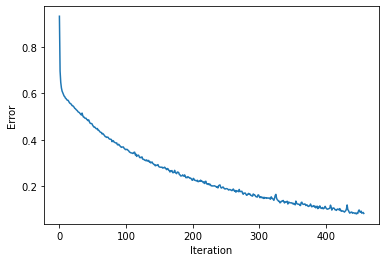

In [26]:
plt.plot(history.loss_curve_)
plt.xlabel("Iteration")
plt.ylabel("Error")